In [1]:
# Global imports
%load_ext autoreload
# import csv
import numpy
import pandas
from tqdm import tqdm
import random
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import HTML, display

import sys
import os

from google_images_download import google_images_download
gid = google_images_download.googleimagesdownload()   #class instantiation

# Loading stats from CSV file

In [8]:
csv_file = "../Datasets/Pokemon/pokemon_alopez247.csv"
with open(csv_file, 'r') as f:
    statistics = pandas.read_csv(f)
print(statistics.columns.values)

pokemon_names = list(statistics["Name"])
cat_to_label = {cat:i for i,cat in enumerate(pokemon_names)}
label_to_cat = {i:cat for i,cat in enumerate(pokemon_names)}

['Number' 'Name' 'Type_1' 'Type_2' 'Total' 'HP' 'Attack' 'Defense'
 'Sp_Atk' 'Sp_Def' 'Speed' 'Generation' 'isLegendary' 'Color' 'hasGender'
 'Pr_Male' 'Egg_Group_1' 'Egg_Group_2' 'hasMegaEvolution' 'Height_m'
 'Weight_kg' 'Catch_Rate' 'Body_Style']


# Scraping images from Google Images

In [28]:
num_images_per_pokemon = 20
offset = 0
image_output_directory = "../Datasets/Pokemon/Images"

pokemon_subset = list(statistics[statistics["Generation"]==1]["Name"])
print("Pokemons : "+str(pokemon_subset))

In [33]:
tqdm_bar = tqdm(pokemon_subset)
for pokemon_name in tqdm_bar:
    tqdm_bar.set_description("Searching for " + pokemon_name)
    
    sys.stdout = open(os.devnull, "w")

    gid.download({
        "keywords":pokemon_name,
        "limit":40,
        "type": "photo",
        "output_directory":image_output_directory,
        "format":"jpg",
        "offset":offset,
        "no_numbering":True
    })

    sys.stdout = sys.__stdout__

Searching for Bulbasaur: 100%|██████████| 1/1 [00:24<00:00, 24.38s/it]


# Preparing datasets

In [34]:
%autoreload 2
import data_processing as DP

training_images = []
training_labels = []
testing_images = []
testing_labels = []

for pokemon in pokemon_subset:
    directory = image_output_directory + "/" + pokemon + "/"
    files = os.listdir(directory)
    random.shuffle(files)
    
    num_files = len(files)
    num_training_files = int(numpy.floor(num_files * 0.9))
    training_files = files[:num_training_files]
    testing_files = files[num_training_files:]
    
    training_images += [os.path.abspath(directory+f) for f in training_files]
    training_labels += [cat_to_label[pokemon] for f in training_files]
    
    testing_images += [os.path.abspath(directory+f) for f in testing_files]
    testing_labels += [cat_to_label[pokemon] for f in testing_files]
    
print("Number of training files in total : "+str(len(training_images)))
print("Number of testing files in total : "+str(len(testing_images)))

In [35]:
%autoreload 2
DP.write_image_vectors_to_file(training_images, 32, training_labels, "../Datasets/Pokemon/train.npy")
DP.write_image_vectors_to_file(testing_images,  32, testing_labels, "../Datasets/Pokemon/test.npy")

Image to vector :   4%|▎         | 380/10205 [00:06<02:25, 67.59it/s] /Users/emiliepicardcantin/anaconda3/lib/python3.6/site-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
Image to vector :  16%|█▋        | 198/1200 [00:03<00:16, 59.95it/s]/Users/emiliepicardcantin/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Image to vector : 100%|██████████| 1200/1200 [00:18<00:00, 63.70it/s]


# Loading vectors and creating training and testing sets

In [2]:
# We only keep classes 0,1,2,3
max_class = 160

training_examples = numpy.load("../Datasets/Pokemon/train.npy")
training_examples = training_examples[:, training_examples[0,:] <= max_class]
print("Train : "+str(training_examples.shape))

testing_examples = numpy.load("../Datasets/Pokemon/test.npy")
testing_examples = testing_examples[:, testing_examples[0,:] <= max_class]
print("Test : "+str(testing_examples.shape))

Train : (1025, 10142)
Test : (1025, 1191)


In [3]:
# We normalize the data.
X_train = training_examples[1:,:] / 255 
Y_train = training_examples[:1, :].astype(int)
print("Train : ")
print("\tX_train : "+str(X_train.shape))
print("\tY_train : "+str(Y_train.shape))
print("\t"+str(Counter(Y_train[0])))

X_test = testing_examples[1:,:] / 255 
Y_test = testing_examples[:1, :].astype(int)
print("Test : ")
print("\tX_test : "+str(X_test.shape))
print("\tY_test : "+str(Y_test.shape))
print("\t"+str(Counter(Y_test[0])))

%autoreload 2
import classification as CL

num_classes = int(numpy.max(Y_train[0])) + 1
train_one_hot = CL.one_hot_matrix(Y_train[0], num_classes)
print("One hot : "+str(train_one_hot.shape))

Train : 
	X_train : (1024, 10142)
	Y_train : (1, 10142)
	Counter({13: 72, 93: 72, 130: 72, 134: 72, 0: 71, 24: 71, 66: 71, 100: 71, 118: 71, 120: 71, 136: 71, 2: 70, 6: 70, 16: 70, 18: 70, 22: 70, 51: 70, 52: 70, 69: 70, 70: 70, 73: 70, 74: 70, 75: 70, 96: 70, 113: 70, 119: 70, 129: 70, 132: 70, 142: 70, 148: 70, 1: 69, 5: 69, 14: 69, 32: 69, 33: 69, 36: 69, 39: 69, 45: 69, 53: 69, 56: 69, 58: 69, 72: 69, 78: 69, 79: 69, 87: 69, 102: 69, 103: 69, 104: 69, 106: 69, 117: 69, 122: 69, 124: 69, 126: 69, 149: 69, 150: 69, 10: 68, 17: 68, 19: 68, 20: 68, 26: 68, 37: 68, 43: 68, 46: 68, 48: 68, 50: 68, 61: 68, 67: 68, 77: 68, 82: 68, 89: 68, 92: 68, 107: 68, 108: 68, 110: 68, 112: 68, 114: 68, 115: 68, 116: 68, 125: 68, 127: 68, 137: 68, 146: 68, 12: 67, 21: 67, 25: 67, 27: 67, 28: 67, 31: 67, 42: 67, 54: 67, 65: 67, 84: 67, 88: 67, 105: 67, 128: 67, 135: 67, 139: 67, 143: 67, 147: 67, 7: 66, 8: 66, 29: 66, 38: 66, 40: 66, 57: 66, 59: 66, 60: 66, 71: 66, 80: 66, 97: 66, 109: 66, 111: 66, 121:

# Training model

In [59]:
%autoreload 2
import classification as CL

num_features = X_train.shape[0]
num_examples = X_train.shape[1]
num_classes = train_one_hot.shape[0]

# Hyperparameters :
n_l = [num_features, 25, 25, num_classes]

# Training model with adam optimization
parameters, costs = CL.nn_model(
    X_train, train_one_hot, n_l,
    initialization="xavier", opt_fnct="adam", 
    learning_rate=0.0001, num_iterations=2000, print_cost=True
)

Cost after iteration 1: 5.095894
Cost after iteration 1001: 4.516653
Cost after all iterations : 3.9872819865674987



In [73]:
parameters, costs = CL.nn_model(
    X_train, train_one_hot, n_l,
    previous_parameters=parameters,
    initialization="xavier", opt_fnct="adam", 
    learning_rate=0.0001, num_iterations=5000, print_cost=True
)

Continuing from previous parameters.
Cost after iteration 1: 0.826525
Cost after iteration 1001: 0.809463
Cost after iteration 2001: 0.788737
Cost after iteration 3001: 0.769467
Cost after iteration 4001: 0.754439
Cost after all iterations : 0.7339050157041418



# Evaluating model

## On training set

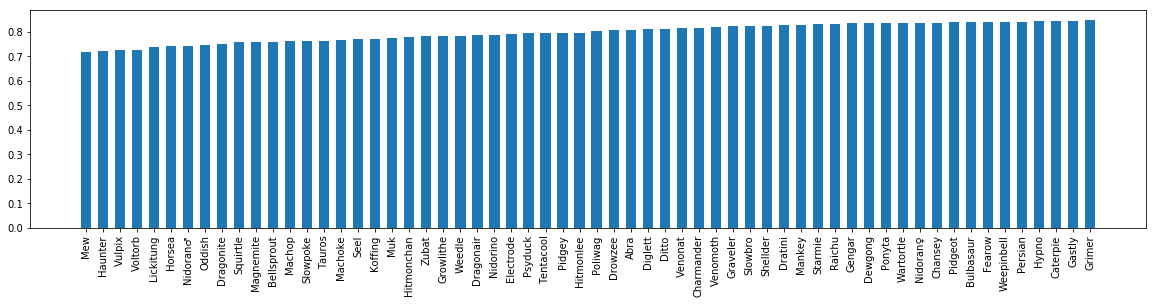

,positive,negative
labels,65,10077
predictions,63,10079
true_predictions,51,10065
false_predictions,12,14


,Global
precision,0.809524
recall,0.784615
f1_score,0.796875


Label : Pidgey


In [77]:
%autoreload 2
import classification as CL

predictions, A_L = CL.predict(parameters["parameters"], X_train, len(n_l)-1, last_act_fnct="softmax") * 1
score_details,f1_details = CL.compute_f1_score_multi_class(predictions, Y_train[0], num_classes)

num_images_per_label = Counter(Y_train[0])

y = [details["f1_score"] for details in f1_details]
y_labels = [i for i in range(len(f1_details))]
tick_labels = [label_to_cat[i] for i in y_labels]

num_data_to_keep = 60
offset_data = 0
sort_order = numpy.argsort(y)
selection = range(offset_data, offset_data+num_data_to_keep)
y = numpy.array(y)[sort_order][selection]
y_labels = numpy.array(y_labels)[sort_order][selection]
tick_labels = numpy.array(tick_labels)[sort_order][selection]
x = range(num_data_to_keep)

fig, ax = plt.subplots() 
fig.set_figwidth(20)
ax.bar(x,y, width=0.6)
ax.set_xticks(x)
ax.set_xticklabels(labels=tick_labels, rotation=90)

# for i in range(num_data_to_keep):
# #     print("i = "+str(i)+", label = "+str(y_labels[i])+", number of images = "+str(num_images_per_label[y_labels[i]]))
#     plt.text(x = x[i]-0.2 , y = y[i]+0.01, s = num_images_per_label[y_labels[i]], size = 16)

plt.show()

df = pandas.DataFrame.from_dict(score_details[15]).reindex(["labels", "predictions", "true_predictions", "false_predictions"])
display(HTML(df.to_html()))

df2 = pandas.DataFrame.from_dict(f1_details[15], orient='index', columns=["Global"])
display(HTML(df2.to_html()))

print("Label : "+str(label_to_cat[15]))

## On testing set

{'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}


,positive,negative
labels,5,604
predictions,3,606
true_predictions,0,601
false_predictions,3,5


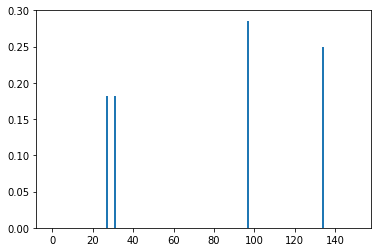

In [23]:
%autoreload 2
import classification as CL

predictions, A_L = CL.predict(parameters, X_test, len(n_l)-1, last_act_fnct="softmax")

score_details,f1_details = CL.compute_f1_score_multi_class(predictions, Y_test[0], num_classes)

y = [details["f1_score"] for details in f1_details]
x = [i for i in range(len(f1_details))]

plt.bar(x,y)

i=0
print(f1_details[i])
df = pandas.DataFrame.from_dict(score_details[i]).reindex(["labels", "predictions", "true_predictions", "false_predictions"])
display(HTML(df.to_html()))

# df2 = pandas.DataFrame.from_dict(f1_score, orient='index', columns=["Global"])
# display(HTML(df2.to_html()))